In [122]:
import json

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import (
    pdist,
    squareform
)


## Example use-case


In [59]:
characters = [
    { 'name': 'Thorr Moddon',
      'attributes' :[{'trait_type': 'Body Armor', 'value': 'Worn Chain'},
                      {'trait_type': 'Weapon', 'value': 'Iron Sword'},
                      {'trait_type': 'Shoulder', 'value': 'Ogre'},
                      {'trait_type': 'Amulet', 'value': 'Copper'}]
    },
    { 'name': 'Marmy Onrett',
      'attributes' :[{'trait_type': 'Body Armor', 'value': 'Worn Chain'},
                      {'trait_type': 'Weapon', 'value': 'Iron Sword'},
                      {'trait_type': 'Shoulder', 'value': 'Barbaric'},
                      {'trait_type': 'Amulet', 'value': 'Copper'}]
    },
    { 'name': 'Sassayl Delron',
      'attributes' :[{'trait_type': 'Body Armor', 'value': 'Draconic'},
                      {'trait_type': 'Weapon', 'value': 'Mihtril Axe'},
                      {'trait_type': 'Shoulder', 'value': 'Barbaric'},
                      {'trait_type': 'Amulet', 'value': 'Copper'}]
    }
]

In [94]:
def create_nft_collection_df(nft_collection):
    def get_attributes_as_df(nft_item):
        attributes = pd.DataFrame.from_records(nft_item['attributes'])
        attributes['nft_name'] = nft_item['name']
        return attributes


    nft_attr = pd.concat([get_attributes_as_df(nft_item) for nft_item in nft_collection])
    nft_attr = nft_attr.reset_index().drop('index', axis=1)

    nft_attr['trait_id'] = nft_attr.groupby(nft_attr[["trait_type", "value"]].\
                                apply(frozenset, axis=1)).ngroup()
    nft_attr['nft_id'] = nft_attr.groupby(nft_attr[['nft_name']].apply(frozenset, axis=1)).ngroup()
    return nft_attr

In [95]:
character_attrs_df = create_nft_collection_df(characters)
character_attrs_df.head(20)

,trait_type,value,nft_name,trait_id,nft_id
0,Body Armor,Worn Chain,Thorr Moddon,0,0
1,Weapon,Iron Sword,Thorr Moddon,1,0
2,Shoulder,Ogre,Thorr Moddon,2,0
3,Amulet,Copper,Thorr Moddon,3,0
4,Body Armor,Worn Chain,Marmy Onrett,0,1
5,Weapon,Iron Sword,Marmy Onrett,1,1
6,Shoulder,Barbaric,Marmy Onrett,4,1
7,Amulet,Copper,Marmy Onrett,3,1
8,Body Armor,Draconic,Sassayl Delron,5,2
9,Weapon,Mihtril Axe,Sassayl Delron,6,2


In [96]:
def create_one_hot_encoded_attributes(attrs_df):
    total_trait = attrs_df['trait_id'].nunique()

    def create_one_hot_encoded_vector(trait_ids):
        trait_vector = pd.Series([False] * total_trait)
        trait_vector[trait_ids] = True
        return trait_vector
    
    return attrs_df.groupby('nft_id')['trait_id'].apply(create_one_hot_encoded_vector).unstack(level=1)

In [104]:
one_hot_encoded_characters = create_one_hot_encoded_attributes(character_attrs_df)
one_hot_encoded_characters.head()

,0,1,2,3,4,5,6
nft_id,,,,,,,
0,True,True,True,True,False,False,False
1,True,True,False,True,True,False,False
2,False,False,False,True,True,True,True


In [103]:
j_distances = 1 - pdist(one_hot_encoded_characters, 'jaccard')
j_distances

array([0.6       , 0.14285714, 0.33333333])

In [102]:
j_distances_df = pd.DataFrame(squareform(j_distances))
j_distances_df.head()

,0,1,2
0,0.000000,0.600000,0.142857
1,0.600000,0.000000,0.333333
2,0.142857,0.333333,0.000000


In [110]:
j_scores = j_distances_df.agg('sum').sort_values()
j_scores.head()

2    0.476190
0    0.742857
1    0.933333
dtype: float64

In [109]:
j_scores = ((j_scores - j_scores.min()) / (j_scores.max() - j_scores.min())) * 100
j_scores.head()

2    100.000000
0     41.666667
1      0.000000
dtype: float64

In [113]:
def calculate_jaccard_score(one_hot_encoded_df):
    j_distances = 1 - pdist(one_hot_encoded_df, 'jaccard')
    j_distances_df = pd.DataFrame(squareform(j_distances))
    j_scores = j_distances_df.agg('sum').sort_values()
    j_scores = ((j_scores - j_scores.min()) / (j_scores.max() - j_scores.min())) * 100 # normalize
    return j_scores

## Working with NFT Collection data

In [154]:
def rarity_score_pipeline(collection_name):
    """
    executes sequential operations to calculate rarity scores 
    based on jaccard distance
    
    |--> loads .json file
    |--> creates pandas.DataFrame from json
    |--> creates one-hot encoded attributes DataFrame
    |--> calculates pair-wise Jaccard distance matrix
        |--> aggregates pair-wise Jaccard distances to calculate 
              rarity score for each NFT
        |--> normalizes rarity scores between 0 and 100
        |--> sort NFT's w.r.t rarity score
    |--> visualize rarity curve and histogram.
    
    returns
    |--> nft_attrs_df from 2nd step
    |--> one_hot_attrs_df from 3rd step
    |--> jaccard_scores from 4th step
    
    """
    
    with open(f'{collection_name}.json', 'rb') as fp:
        nft_collection = json.load(fp)
        
    nft_attrs_df = create_nft_collection_df(nft_collection)
    
    one_hot_attrs_df = create_one_hot_encoded_attributes(nft_attrs_df)
    
    jaccard_scores = calculate_jaccard_score(one_hot_attrs_df)
    
    fig, ax = plt.subplots(2,1)
    fig.tight_layout()
    sns.lineplot(jaccard_scores.values, ax=ax[0]).set_title(f'Rarity curve of {collection_name}')
    sns.histplot(jaccard_scores.values, kde=True, ax=ax[1]).set_title(f'Rarity distribution of {collection_name}')
    return nft_attrs_df, one_hot_attrs_df, jaccard_scores

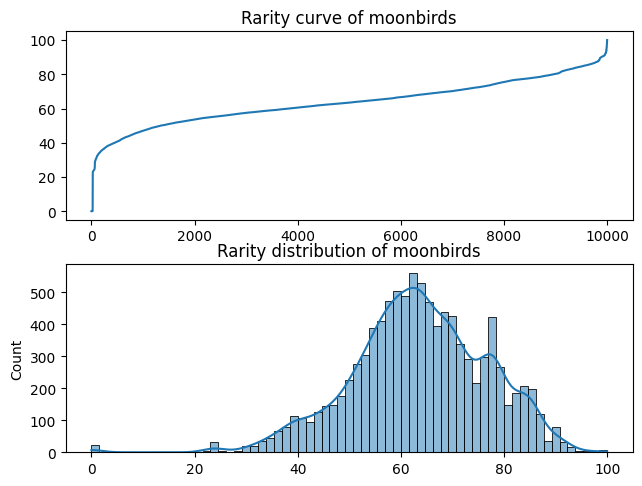

In [156]:
moonbirds_results =  rarity_score_pipeline('moonbirds')

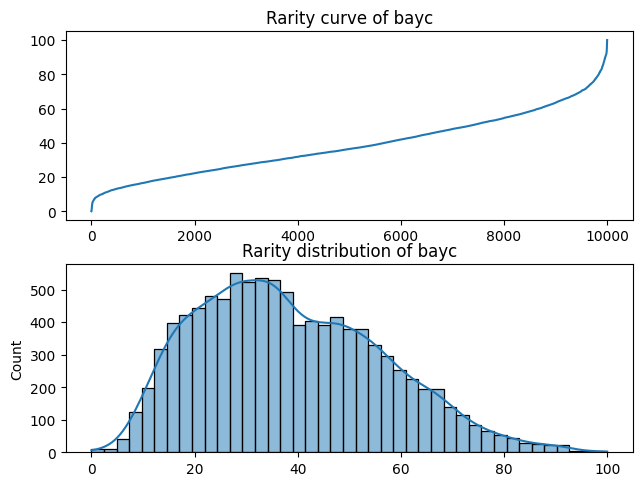

In [ ]:
bayc_results =  rarity_score_pipeline('bayc')